In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")



# <div class=consignes>Deep Learning et traitement du signal TP 1 </div>
<div class=consignes> L'objectif de ce TP est de prendre en main les outils de modélisation et d'analyse du signal présentés dans le premier cours et d'introduire la problématique de <it>détection</it> dont on parlera dans le cours numéro 3 </div>
<div class=consignes>Deadline de rendu : 15 octobre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br> Effort estimé : 2 à 3 heures maximum</div>
<div class=consignes>Le rendu de ce TP n'est pas obligatoire. Il permet d'obtenir un bonus de 1 (minimum syndical) à 3 (votre notebook servira de correction l'an prochain) points sur la moyenne des TP </div>

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp1.ipynb </div>

(Ruben, Cardoso)

<div class=consignes>Si vous installez des paquets supplémentaires, merci de les lister dans la cellule suivante avec la syntaxe
    
```
!pip install \< nom_du_paquet \>
```
    
</div>

In [2]:
!pip install pydub ffmpeg



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np 
import matplotlib.pylab as plt 
import scipy
from scipy.io import wavfile
import IPython.display as ipd
from pydub import AudioSegment

## <div class=consignes>Partie 1: Audio </div>

### <div class=consignes>Visualisation</div>

 <div class=consignes>Enregistrez un fichier wav de quelques secondes de votre voix. 
  <br>
 Importez le avec scipy.io.wavfile.read et écoutez le dans le notebook avec IPython.display.Audio
</div>

In [4]:
#Charging the file
audio = AudioSegment.from_file('/Users/veroniquemohy-cardoso/Downloads/Nouvel enregistrement 2.m4a')

#wav : 
audio.export("ma_voix.wav", format="wav")

print("Conversion done : ma_voix.wav créé")

fs, x = wavfile.read("ma_voix.wav")

# Play it
ipd.Audio(x, rate=fs)



Conversion done : ma_voix.wav créé


<div class=consignes>Visualisez la forme d'onde temporelle de ce signal audio. <br>
Estimez et affichez sa Densité Spectrale de Puissance. <br>
Donnez une interprétation de ce que vous observez. 
    </div>

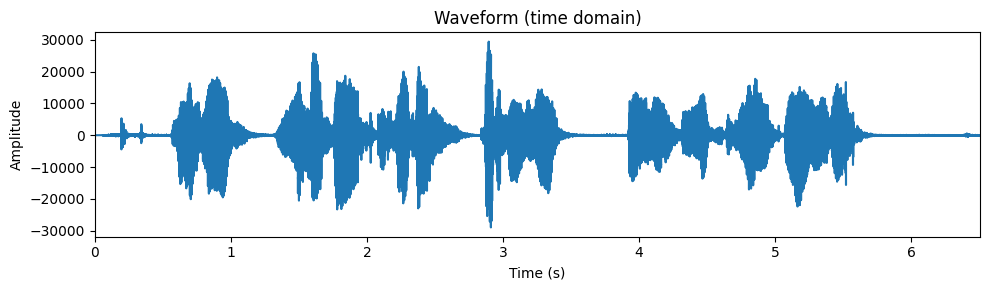

In [5]:
#1) Time domain waveform : 
#time axis

x_plot = x
t = np.linspace(0, len(x_plot)/fs, len(x_plot), endpoint=False)

plt.figure(figsize=(10,3))
plt.plot(t, x_plot)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform (time domain)")
plt.xlim(0, t[-1])
plt.tight_layout()
plt.show()

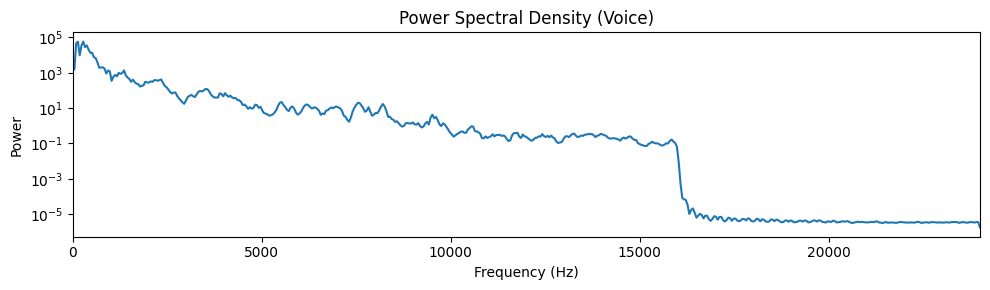

In [6]:
#2) Power spectral density : 

from scipy.signal import welch

# Welch PSD estimation
f, Pxx = welch(x, fs=fs, nperseg=1024)

plt.figure(figsize=(10, 3))
plt.semilogy(f, Pxx)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectral Density (Voice)")
plt.xlim(0, fs/2) 
plt.tight_layout()
plt.show()

#We used the Welch method as introduced during first class. 

*Interpretation*: 

The PSD shows that most of the energy of my voice is concentrated in low frequencies, which is typical for speech. The energy gradually decreases at higher frequencies, which is expected because smooth signals like the human voice naturally contain weaker high-frequency components.

<div class=consignes> Calculez et affichez le spectrogramme du signal. <br>
Justifiez du choix des réglages que vous avez faits. <br>
Sélectionnez une portion pertinente du spectrogramme pour estimer visuellement le pitch de votre voix.
    </div>

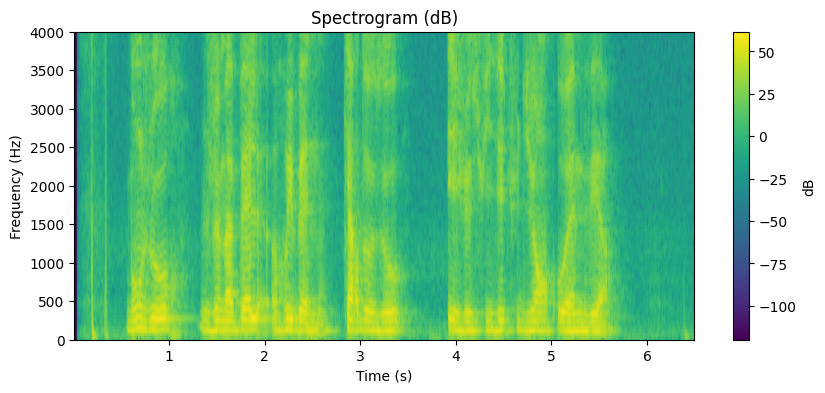

In [7]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

f, t_spec, Sxx = spectrogram(x, fs=fs, nperseg=1024, noverlap=512, window='hamming')

plt.figure(figsize=(10,4))
plt.pcolormesh(t_spec, f, 10*np.log10(Sxx+1e-12), shading='gouraud')
plt.ylim(0, 4000)  # Focus on speech range
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (dB)")
plt.colorbar(label="dB")
plt.show()



According to course slides : we used nperseg = 1024 to obtain a good compromise between time and frequency resolution. A larger window improves frequency detail but can smooth out rapid transitions, while a smaller window increases time precision but loses harmonic clarity.
We set the overlap to noverlap = 512 (50%) in order to make the spectrogram smoother over time, relatively increasing the time-frequency trade-off. 
Finally, we applied a Hamming window to reduce spectral leakage and limit secondary lobes.


I selected a stable vowel region in the spectrogram (around 2–3 seconds), where horizontal harmonic lines are visible. The lowest harmonic in this region represents the fundamental frequency (pitch) of my voice.

### <div class=consignes>Calcul du Pitch</div>

<div class=consignes>Proposez une méthode simple pour estimer automatiquement le Pitch de votre voix (cette méthode ne doit pas faire intervenir d'implémentations externes).

Utilisez cette méthode pour estimer les variations du Pitch le long du signal, estimez le pitch toutes les 20 ms et présentez vos résultats sous forme visuelle. 

Ne pas utiliser de méthode "toute faite" que vous pourriez par exemple trouver dans la bibliothèque librosa.

Commentez vos résultats.
    </div>

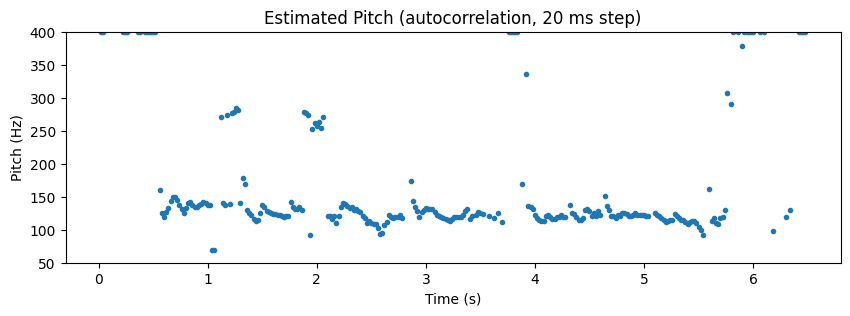

In [8]:
# mono & zero-mean
sig = x.mean(axis=1) if x.ndim == 2 else x
sig = sig.astype(float) - np.mean(sig)

# framing params
hop = int(0.020 * fs)         # 20 ms between estimates
win = int(0.040 * fs)         # 40 ms analysis window (stable F0)
lag_min = int(fs / 400)       # search range: 60–400 Hz (typical voice)
lag_max = int(fs / 60)

times, f0 = [], []

for start in range(0, len(sig) - win, hop):
    frame = sig[start:start+win] * np.hamming(win)
    ac = np.correlate(frame, frame, mode='full')[win-1:]   # autocorr, non-negative lags

    # find peak in valid lag range
    r = ac[lag_min:lag_max]
    k = np.argmax(r) + lag_min
    peak = ac[k]

    # voiced/unvoiced decision: peak must be strong enough
    f0_est = fs / k if peak > 0.3 * ac[0] else np.nan

    f0.append(f0_est)
    times.append((start + win/2) / fs)

# plot pitch track
plt.figure(figsize=(10,3))
plt.plot(times, f0, marker='.', linestyle='none')
plt.ylim(50, 400); plt.xlabel("Time (s)"); plt.ylabel("Pitch (Hz)")
plt.title("Estimated Pitch (autocorrelation, 20 ms step)")
plt.show()


To estimate the pitch, I used an approach based on autocorrelation.  
Since voiced speech is quasi-periodic, I analysed short frames of 40 ms and measured how well the signal correlates with a delayed version of itself.  
The lag giving the strongest peak (within 60–400 Hz) is taken as the fundamental period, and the pitch is computed as:

$f_0 = \frac{fs}{\text{lag}}$ 

Pitch was estimated every 20 ms to follow its variation over time.

*Interpretation*: 
The estimated pitch mostly stays between 100 Hz and 150 Hz, which is consistent with a typical male voice.  
Although some fluctuations appear at transitions or unvoiced segments, no clear periodicity is detected.


## <div class=consignes>Partie 2: Détection d'impulsion </div>

<div class=consignes> Un signal de durée 1 seconde et échantillonné à 1000 Hz est composé d'un bruit blanc gaussien de puissance inconnue et éventuellement d'une impulsion à une fréquence f0 comprise entre 100 et 200 Hz. 
<br><br>
Une série de 1000 signaux est enregistrée dans le fichier signaux_impulsions.npz. 
Ouvez ce fichier avec numpy (cf code plus bas). Le fichier contient une tableau signaux 10000 x 1000 dont chaque ligne contient un signal de durée 1000. Le fichiez contient aussi un tableau labels de taille 10000 dont la ligne i est à TRUE si le signal i contient une impulsion et à 0 sinon. 

</div>

In [9]:
import numpy as np
donnees = np.load('/Users/veroniquemohy-cardoso/Downloads/signaux_impulsions.npz')
print(donnees.files)
signaux = donnees['data']
labels   = donnees['labels']

['data', 'labels']


## <div class=consignes> Première méthode </div>

<div class=consignes> Proposez une méthode simple  pour décider si un signal contient une impulsion ou non à partir du calcul de l'énergie du signal. Cette méthode fera intervenir un seuil: 
</div>

In [10]:
def contient_impulsion_energie(signal: np.ndarray, seuil: float) -> bool:
    energie = np.sum(signal**2)
    return energie > seuil


<div class=consignes>
Utilisez votre méthode avec un seuil fixé sur tous les signaux pour prédire s'ils contiennent une impulsion ou non. 
</div>

In [11]:
# Compute energy of each signal (sum of squares)
energies = np.sum(signaux**2, axis=1)

# chosing a threshold 
seuil = np.median(energies)

# 3) Predictions using the energy-based method
preds = energies > seuil
y = labels.astype(bool)

<div class=consignes>
Calculez: <br>
- VP = le nombre de signaux que vous détectez comme contenant une impulsion qui contiennet effectivement une impulsion <br>
- FP = le nombre de signaux que vous détectez comme contenant une impulsion qui ne contiennet en fait PAS une impulsion <br>
- VN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion qui ne contiennet effectivement PAS une impulsion<br>
- FN = le nombre de signaux que vous détectez comme ne contenant PAS une impulsion mais qui  contiennet en fait une impulsion
</div>

In [12]:
VP = np.sum(preds & y)     
FP = np.sum(preds & ~y)     
VN = np.sum(~preds & ~y)  
FN = np.sum(~preds & y)

print(f"Threshold: {seuil:.2f}")
print(f"VP: {VP}, FP: {FP}, VN: {VN}, FN: {FN}")

Threshold: 211.58
VP: 2992, FP: 2008, VN: 2988, FN: 2012


## <div class=consignes>Deuxième méthode </div>

<div class=consignes>Proposez une deuxième méthode faisant par exemple intervenir le spectrogramme du signal. Cette méthode fera encore intervenir un seuil
</div>

```python
def contient_impulsion_spectrogramme(signal: np.ndarray, seuil: float) -> bool:
```


The impulse frequency is expected between 100 and 200 Hz, as stated in the problem.
Therefore, we only study the energy in this band.
An impulse produces a sharp local peak in this range, which allows us to detect it in the spectrogram

In [13]:
# Computing a score per signal 
def contient_impulsion_spectrogramme(sig: np.ndarray) -> float:
    f, t, Sxx = spectrogram(sig, fs=1000, nperseg=1000,
                            noverlap=512, window='hamming',
                            scaling='spectrum', mode='psd')
    band = (f >= 100) & (f <= 200)
    return np.max(Sxx[band].sum(axis=0))

scores = np.array([contient_impulsion_spectrogramme(sig) for sig in signaux])

# threshold 
seuil = np.median(scores) 

# Predictions 
preds = scores > seuil
y = labels.astype(bool)

TP = np.sum(preds & y)
FP = np.sum(preds & ~y)
TN = np.sum(~preds & ~y)
FN = np.sum(~preds & y)

print(f"Threshold: {seuil:.4g}")
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")


Threshold: 0.08153
TP: 3736, FP: 1264, TN: 3732, FN: 1268


<div class=consignes> Calculez pour cette nouvelle méthode, pour un certain seuil les valeurs de VP, FP, VN, FN </div>

## <div class=consignes> Comparaison des méthodes </sdivs>

For a given detector and threshold, we use:
$
\textbf{Precision}=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FP}},\qquad
\textbf{Recall}=\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}.
$
Equivalently, using set sizes:
$
\text{Precision}=\frac{\big|\{\text{detected as impulse}\}\cap\{\text{true impulse}\}\big|}
{\big|\{\text{detected as impulse}\}\big|},\quad
\text{Recall}=\frac{\big|\{\text{detected as impulse}\}\cap\{\text{true impulse}\}\big|}
{\big|\{\text{true impulse}\}\big|}.
$


<div class=consignes> Donnez une interprétation de ces deux métriques </div>

Precision tells how many detected impulses are correct. Recall tells how many real impulses we managed to detect

<div class=consignes>
    Pour chacune des deux méthodes proposées, faites varier le seuil sur une dizaine de valeurs et calculez la précision et le rappel pour chacun de ces seuils. 

Affichez dans le plan (précision , rappel) les points de fonctionnement des deux méthodes pour différents seuils. <br>Commentez le résultat. 
    </div>

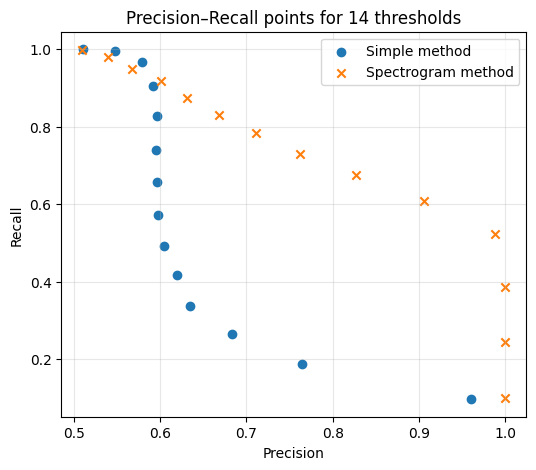

In [14]:
def pr_curve(scores, y, qmin=0.02, qmax=0.95, n=10):
    """Return precision and recall for a range of thresholds between quantiles."""
    ths = np.quantile(scores, np.linspace(qmin, qmax, 14))
    precisions, recalls = [], []
    for th in ths:
        preds = scores > th
        TP = np.sum(preds & y)
        FP = np.sum(preds & ~y)
        FN = np.sum(~preds & y)
        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        precisions.append(prec)
        recalls.append(rec)
    return np.array(precisions), np.array(recalls), ths

# plot :
p1, r1, th1 = pr_curve(energies, y)
p2, r2, th2 = pr_curve(scores, y)

plt.figure(figsize=(6,5))
plt.scatter(p1, r1, label='Simple method', marker='o')
plt.scatter(p2, r2, label='Spectrogram method', marker='x')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision–Recall points for 14 thresholds')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The spectrogram-based method clearly outperforms the total energy detector. It maintains a high precision even when recall increases, which means it successfully captures short impulses without producing many false alarms. The total energy method trades precision for recall and misses most impulses unless the threshold is drastically lowered.